# Health Inspection Outcome Prediction – Process Notebook

## 1. Overview and Motivation

**Project Goal:** Predict the outcome of restaurant inspections (*Pass*, *Conditional Pass*, *Closure*) using historical inspection data.  

**Motivation:**  
- Support inspectors in decision-making by providing an evidence-based second opinion.  
- Focus on categorical outcomes rather than a numerical health score, aligning predictions with operational decisions.  
- Handle challenges such as class imbalance, temporal correlation, and weak static feature signal.  

**Additional Use Cases:**  
1. **Inspector Dashboard:** Provide inspectors with a dashboard summarizing historical inspection data. This allows them to identify and prioritize high-risk restaurants in advance of upcoming inspection cycles.  
2. **Customer Insights:** Present inspection results to customers in a simple, intuitive format. Customers can select a neighborhood and view restaurants’ recent inspection history (e.g., last 3–5 inspections) and combined health and Google review scores, helping them make informed dining choices.  

**Operational Target:** Predict inspection outcomes for a restaurant given current inspection observations with the help of  historical patterns.  

**Non-trivial aspects:**  
- Highly imbalanced classes (Closure/Conditional Pass are rare).  
- Strong temporal structure: past inspections influence future outcomes.  
- Static features alone are insufficient to explain outcomes.



## 2. Related Work

A relevant prior work is available in a Medium article titled *“Machine teaching restaurant inspection health scores”* by Jay Ozer. This project also used the San Francisco inspection dataset (2016–2019) from DataSF and focused on understanding and preparing the data for predictive analysis.

In that work, the author encountered similar data quality challenges, such as poorly structured text fields, missing or incorrect geographic information, and the need to derive predictive features from inspection records. NLP techniques were also explored for processing the “violation_description” text field, including clustering and word frequency analysis.

Although the focus was partly on visualization and feature derivation rather than predictive models, the article demonstrates the importance of data cleaning, text preprocessing, and feature engineering in restaurant inspection prediction tasks. It also highlights that simpler models like random forests can perform reasonably well once features are curated, a point that aligns with our own modeling decisions.

Link to the article: https://medium.com/analytics-vidhya/machine-teaching-restaurant-inspection-health-scores-eb7f2201a964

Also, Papers on **risk-based inspection prioritization** show the value of historical inspection data for predictive modeling.

## 3. Initial Questions

**Starting Questions:**
- Can **violation count** predict inspection outcomes?  
- Are certain **violation codes** strong indicators of outcomes?  
- Does **inspection type or frequency** correlate with inspection severity?  

**Findings:**  
- Static features showed weak or inconsistent correlation with outcomes.  
- Early assumptions were largely invalidated by exploratory data analysis.

**New Questions After EDA:**
- Which features truly influence outcomes?  
- How to handle class imbalance?  
- Can historical/temporal patterns improve prediction? 

## 4. Data Source and Construction

- **Source:** San Francisco open data portal (Health and Social Services).  
- **Format:** CSV files, imported and processed locally.  
- **Unit:** Each row represents **one inspection**.  
- **Time Span:** 2020–present; earlier datasets were merged to increase minority class coverage.  

**Data Quality Challenges:**
- Missing or null values across many columns.  
- Redundant geographic data (latitude, longitude, point, address, postal code).  
- Textual violation descriptions that were difficult to process.  
- Inconsistent column schemas across datasets (across the years).  

**Preprocessing:**
- Mandatory: Impute missing values, drop duplicates and irrelevant columns, careful merge of datasets.  
- Optional: NLP on violation descriptions (not performed).  

## 5. Exploratory Data Analysis (EDA)

**Target Variable:** `facility_rating_status` – three classes:
- Pass ≈ 95%  
- Conditional Pass ≈ few percent  
- Closure ≈ few percent  

**Insights from Plots:**
- `violation_observed` (available only in 2020–2023) correlated with high-risk outcomes.  
- Initial assumptions on violation count/code were invalidated.  
- Temporal features such as historical outcomes showed strong predictive potential.  

**Patterns Observed:**
- Past inspection outcomes dominate predictive signal.  
- Static inspection features are weak predictors.

**Conclusion from EDA:** Focus on **historical and temporal features** rather than static attributes.

## 6. Feature Engineering

**Created Features (all temporal/historical):**
1. `prev_rating_majority_3` – majority rating of last three inspections.  
2. `days_since_last_inspection` – days since previous inspection.  
3. `avg_violation_count_last_3` – average violations over last three inspections.  
4. `is_first_inspection` – binary flag for first inspection.  

**Most Predictive Features:** Historical outcomes and temporal patterns.  

**Leakage Risk & Safeguards:**
- Temporal splits ensured features used only past inspections.  
- Train Test split based on Date.  
- Prevented future information leakage into training.

## 7. Modeling Choices

**Baseline:** Random Forest.  

**Other Models Tried:**
- KNN and Decision Trees (discarded due to poor performance on imbalanced data).  
- XGBoost was also tuned but Random Forest performed better on minority classes.  

**Final Model:**  
- Random Forest with tuned parameters and class weights for minority classes.  
- Optimized **F1 score for Closure and Conditional Pass**, ignoring overall accuracy due to imbalance.  

**Strategies tried:**  
- Class weighting  
- Over- and under-sampling  
- Grid search for model parameters  

## 8. Evaluation Strategy

**Initial Split:** Random – led to temporal leakage, inflated metrics.  

**Corrected Split:** Time-based – train on past inspections, test on future inspections.  

**Effect:** Metrics decreased to reflect true model performance; avoided misleading results caused by leakage.

## 9. Final Results and Interpretation

**Strengths:**  
- High precision (~90%) on minority classes when predicted.  
- Captures some Conditional Pass and Closure cases beyond a naive persistence baseline.  

**Weaknesses:**  
- Low recall for Closure – fails to identify many high-risk cases.  
- Feature importance dominated by `prev_rating_majority_3`, reflecting temporal correlation rather than causal insight.  


**Final model performs better, especially for Conditional Pass detection.**

## 10. Limitations and Future Work

**Limitations:**  
- Dependent on historical and static data; performance degrades if the dataset is not continuously updated.  
- Rare outcomes (Closure) remain under-detected.  

**Future Improvements:**  
- Incorporate **additional data** as new inspections occur.  
- Preferably use a single dataset with a **consistent column schema** to avoid merge complications.  
- Explore additional predictive features for operational or environmental factors.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Optional: make plots inline in Jupyter
%matplotlib inline


from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score
)


In [2]:
df = pd.read_csv('../data/clean/dataset_visualization.csv')

### Class distribution

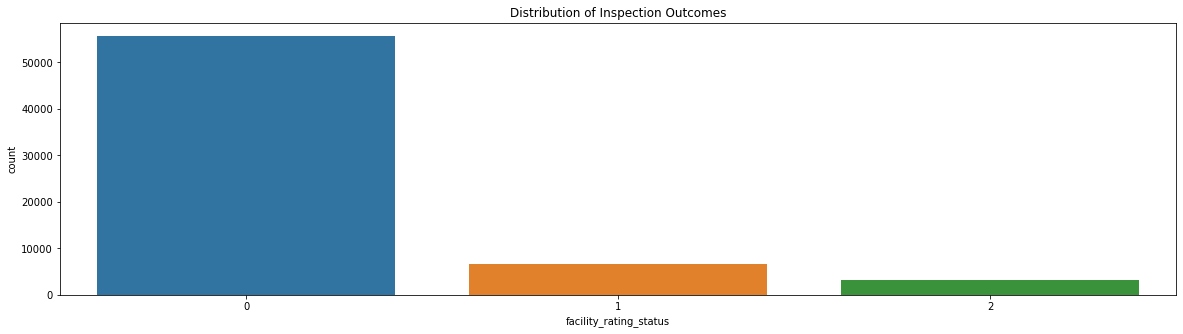

In [4]:
plt.figure(figsize=(20,5))
sns.countplot(x='facility_rating_status', data=df)
plt.title('Distribution of Inspection Outcomes')
plt.show()


### Show trend of rating for a single restaurant (example)


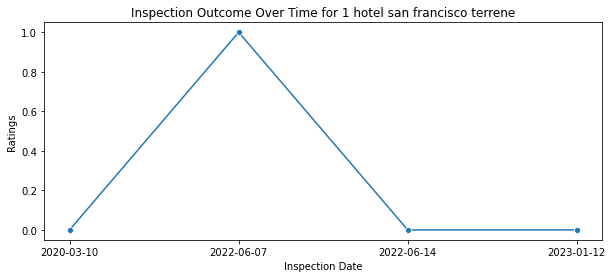

In [5]:
restaurant = df['name'].unique()[0]
df_rest = df[df['name'] == restaurant]

plt.figure(figsize=(10,4))
sns.lineplot(x='inspection_date', y='facility_rating_status', data=df_rest, marker='o')
plt.title(f'Inspection Outcome Over Time for {restaurant}')
plt.xlabel('Inspection Date')
plt.ylabel('Ratings')
plt.show()



### Correlation between Features 

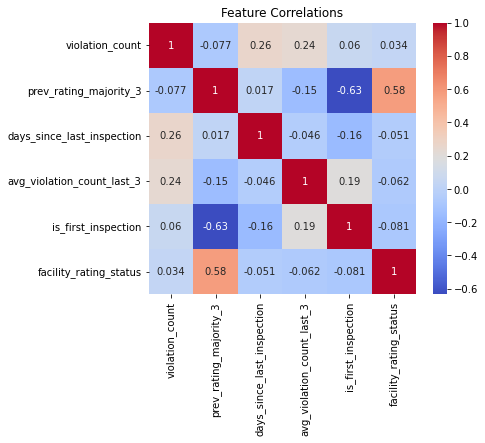

In [6]:
# Only numerical features
numeric_features = ['violation_count','prev_rating_majority_3', 'days_since_last_inspection', 'avg_violation_count_last_3', 'is_first_inspection']
plt.figure(figsize=(6,5))
sns.heatmap(df[numeric_features + ['facility_rating_status']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()


In [7]:

# Load
model = joblib.load('model/random_forest_multiclass.pkl')


In [8]:
df_model = pd.read_csv('../data/clean/model_dataset.csv')

X = df_model.drop(['facility_rating_status'], axis = 1)
Y = df_model['facility_rating_status']


In [9]:
def split_vals(X,Y):
    # 70/30 split
    global X_train, X_test, Y_train, Y_test
    split_idx = int(len(X) * 0.70)
    X_train = X.iloc[:split_idx].copy()
    X_test  = X.iloc[split_idx:].copy()
    Y_train = Y.iloc[:split_idx].copy()
    Y_test  = Y.iloc[split_idx:].copy()
    return None

In [10]:
split_vals(X,Y)

In [11]:
#Standardising the data for the building the model
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Results and Curves 

Optimal threshold for class 2: 0.611777514451344
Best F1 score for class 2: 0.3903095526321034


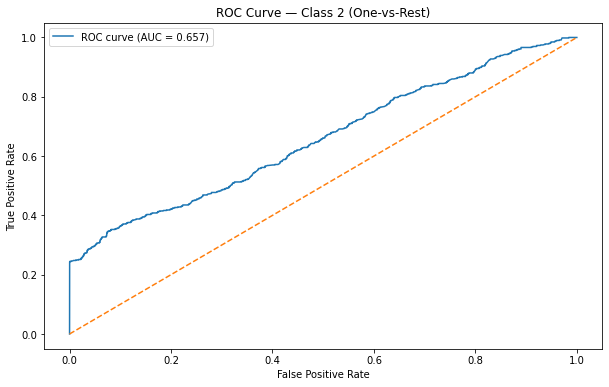

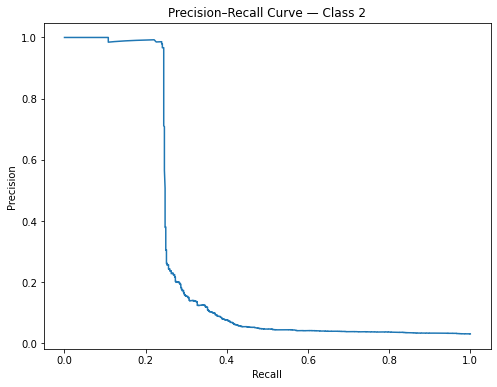

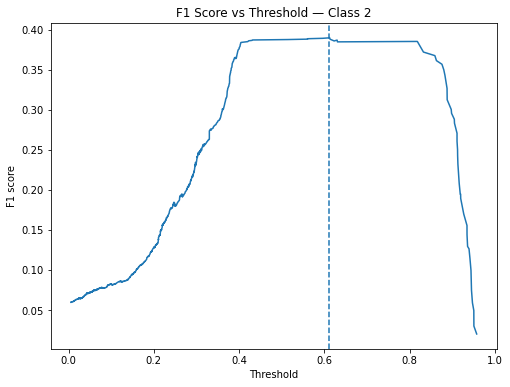

In [12]:

# Predict probabilities
y_proba = model.predict_proba(X_test)          
y_proba_class2 = y_proba[:, 2]                 

# Binary ground truth for class 2 (one-vs-rest)
y_test_bin = (Y_test == 2).astype(int)

# Precision–Recall + Threshold tuning 
precision, recall, thresholds_pr = precision_recall_curve(
    y_test_bin,
    y_proba_class2
)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

optimal_idx = np.argmax(f1_scores[:-1])       # exclude last point
optimal_threshold = thresholds_pr[optimal_idx]

print("Optimal threshold for class 2:", optimal_threshold)
print("Best F1 score for class 2:", f1_scores[optimal_idx])

# ROC curve for class 2 
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_class2)
roc_auc = roc_auc_score(y_test_bin, y_proba_class2)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Class 2 (One-vs-Rest)")
plt.legend()
plt.show()

# Precision–Recall curve 
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Class 2")
plt.show()

# F1 vs Threshold 
plt.figure(figsize=(8, 6))
plt.plot(thresholds_pr, f1_scores[:-1])
plt.axvline(optimal_threshold, linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.title("F1 Score vs Threshold — Class 2")
plt.show()


### Temporal vs Target Variable

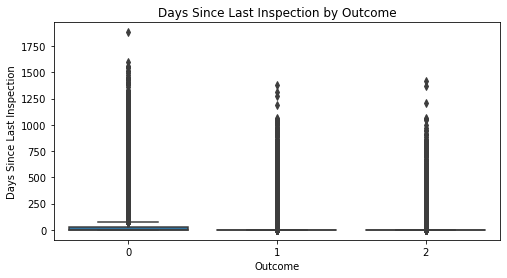

In [13]:
plt.figure(figsize=(8,4))
sns.boxplot(x='facility_rating_status', y='days_since_last_inspection', data=df)
plt.title('Days Since Last Inspection by Outcome')
plt.xlabel('Outcome')
plt.ylabel('Days Since Last Inspection')
plt.show()


### Violation Count vs Rating

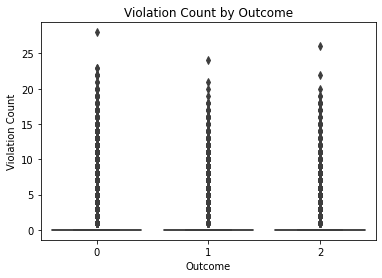

In [14]:
plt.figure(figsize=(6,4))
sns.boxplot(x='facility_rating_status', y='violation_count', data=df)
plt.title('Violation Count by Outcome')
plt.xlabel('Outcome')
plt.ylabel('Violation Count')
plt.show()


In [15]:
#Both doesn't have much impact on our target variable. It does not help to differentiate the classes

### Above are few important visualizations to gain some insights about the data and our features
